In [1]:
import tensorflow as tf
# tfe = tf.contrib.eager
# tf.enable_eager_execution()

from tensorflow.keras import layers

from tensorflow.keras import backend as K

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
#import PIL
import imageio
from IPython import display
import pathlib
AUTOTUNE=tf.data.experimental.AUTOTUNE

In [12]:
K.set_floatx('float16')

In [3]:
dir=pathlib.Path.cwd()/'celebfaces/'

In [4]:
all_image_paths=list(dir.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]
image_count = len(all_image_paths)
image_count

train_paths=all_image_paths[:-20000]
test_paths=all_image_paths[-20000:]

In [5]:
all_image_paths[0]

'C:\\Users\\Isaiah\\jupyter\\celebfaces\\000001.jpg'

In [9]:
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [192, 192])
  image /= 255.0  # normalize to [0,1] range
  image = tf.image.convert_image_dtype(image, tf.float16)

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)


def from_path_to_tensor(paths, batch_size):
    path_ds=tf.data.Dataset.from_tensor_slices(paths)
    image_ds=path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    ds=image_ds.repeat()
    ds=ds.batch(batch_size)
    ds=ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [10]:
BATCH_SIZE = 128
BUFFER_SIZE=image_count//9

train_set= from_path_to_tensor(train_paths, BATCH_SIZE)
test_set=from_path_to_tensor(test_paths, BATCH_SIZE)

In [13]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(192, 192, 3)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=16, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=8, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=24*24*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(24, 24, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=4,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=8,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=16,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),  
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=3, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid'),
        ]
    )

  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(4, self.latent_dim))
    return self.decode(eps)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z):
    return self.generative_net(z)

In [14]:
optimizer=tf.keras.optimizers.Adam(1e-4)
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_r = model.decode(z)

    rc_loss = K.sum(K.binary_crossentropy(
    K.batch_flatten(x), 
    K.batch_flatten(x_r)), axis=-1)

    # Regularization term (KL divergence)
    kl_loss = -0.5 * K.sum(1 + logvar \
                             - K.square(mean) \
                             - K.exp(logvar), axis=-1)
    
    # Average over mini-batch
    return K.mean(rc_loss + kl_loss)


def compute_gradients(model, x):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
     optimizer.apply_gradients(zip(gradients, variables))
    

In [15]:
epochs = 1
latent_dim = 50
num_examples_to_generate = 4

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [16]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(2,2))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [18]:
#generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  i=0
  for batch in train_set:
    i+=1
    gradients, loss = compute_gradients(model, batch)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    if i % 10 ==0:
        print('Batch ',i,', done.')
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_set:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
            'time elapse for current epoch {}'.format(epoch,
                                                        elbo,
                                                        end_time - start_time))

    generate_and_save_images(
            model, epoch, random_vector_for_generation)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a half tensor [Op:Mul] name: mul/

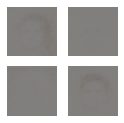

In [36]:
generate_and_save_images(model, 0 ,random_vector_for_generation)

In [16]:

model.load_weights('modelweights_epoch001_batch3000.h5')

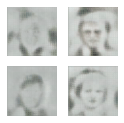

In [17]:
generate_and_save_images(model, 1,random_vector_for_generation)

In [8]:
train_set

<PrefetchDataset shapes: (None, 192, 192, 3), types: tf.float32>